# Combining models
****
Here we will combine the classifier who chose to first classify each observation into a range for 'logerror' and then within each range, run a regression.

In [86]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.gridspec as gridspec
import datetime
import math
import sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [87]:
Housing = pd.read_csv('cleaned_1.csv')
Housing = Housing.set_index(['parcelid','Unnamed: 0'])
Housing['transactiondate'] = pd.to_datetime(Housing['transactiondate'], format = '%Y-%m-%d', errors = 'coerce')
Housing['taxamount'] = Housing['taxamount']*100
#bins = [-5.5,-2,-0.1,0.1,0.75,2,5.5]
#Housing['binned'] = pd.cut(Housing['logerror'], bins = bins, labels= bins[1:])
#Housing['binned'].value_counts()

imp_cols = ['calculatedfinishedsquarefeet', 'latitude','longitude','lotsizesquarefeet','bathroomcnt',
            'taxamount','structuretaxvaluedollarcnt', 'taxvaluedollarcnt','landtaxvaluedollarcnt',
            'yearbuilt', 'bedroomcnt','buildingqualitytypeid','regionidzip','rawcensustractandblock',
            'regionidneighborhood']

X_df = Housing[imp_cols].astype(int)
Y_df = Housing['logerror']#Housing['binned'].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, random_state = 5)
Y_df.head()

parcelid  Unnamed: 0
17073783  0             0.0953
17088994  1             0.0198
17100444  2             0.0060
17102429  3            -0.0566
17109604  4             0.0573
Name: logerror, dtype: float64

In [111]:
def Double_Model(X_predict, X_train, y_train):
    # First we will do some cleaning
    bins = [-5.5,-2,-0.1,0.1,0.75,2,5.5]
    #train_bins = pd.cut(y_train, bins = bins, labels= bins[1:]).cat.codes
    imp_cols = ['calculatedfinishedsquarefeet', 'latitude','longitude','lotsizesquarefeet','bathroomcnt',
            'taxamount','structuretaxvaluedollarcnt', 'taxvaluedollarcnt','landtaxvaluedollarcnt',
            'yearbuilt', 'bedroomcnt','buildingqualitytypeid','regionidzip','rawcensustractandblock',
            'regionidneighborhood']
    X_train['binned'] = pd.cut(y_train, bins = bins, labels= bins[1:]).cat.codes
    y_df = pd.DataFrame()
    y_df['logerror'] = y_train
    y_df['binned'] = pd.cut(y_train, bins = bins, labels= bins[1:]).cat.codes
    
    # HERE WE WILL FILL IN NULL VALUES IF NECESSARY
    # Additionall, we may need to prepare the data if it is to be inputted raw
    
    
    
    
    # Here we adjust taxamount IF NEEDED IN MODEL
    
    
    
    # create new index to reserve initial order
    
    
    
    X_predict = X_predict.sort_index()
    
    clf = RandomForestClassifier(n_estimators = 10, max_features = 3, bootstrap = True, random_state = 5)
    clf.fit(X_train[imp_cols], X_train['binned'])
    
    predicted_bins = clf.predict(X_predict[imp_cols])
    X_predict['binned'] = predicted_bins
    
    predicted_dfs = []
    for i in X_train['binned'].unique():
        df_train = X_train[X_train['binned'] == i]
        df_y_train = y_df[y_df['binned'] == i]
        df_pred = X_predict[X_predict['binned'] == i]
        #df_predict = df_pred[imp_cols]
        
        df_train = df_train.astype(float)
        df_pred = df_pred.astype(float)
        df_train['taxamount'] = df_train['taxamount'] / 100
        df_pred['taxamount'] = df_pred['taxamount'] / 100
        
        poly = PolynomialFeatures(degree=1)
        X_train_poly = poly.fit_transform(df_train[imp_cols])
        X_test_poly = poly.fit_transform(df_pred[imp_cols])
        lr = LinearRegression().fit(X_train_poly, df_y_train['logerror'])
        
        df_pred['predicted'] = lr.predict(X_test_poly)
        predicted_dfs.append(df_pred['predicted'])
    
    S = predicted_dfs[0].append(predicted_dfs[1:])
    
    S = S.sort_index()
    return S

#Double_Model(X_test, X_train, y_train)

In [112]:
y_test

Results = pd.DataFrame()
Results['predicted'] = Double_Model(X_test, X_train, y_train)
Results['real'] = y_test

print("Mean squared error: {:.2f}".format(mean_squared_error(Results['real'], Results['predicted'])))
print("r2_score: {:.2f}".format(r2_score(Results['real'], Results['predicted'])))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Mean squared error: 0.03
r2_score: -0.09


In [113]:
Results['predicted'].max()

2.4343207004145846

<IPython.core.display.Javascript object>


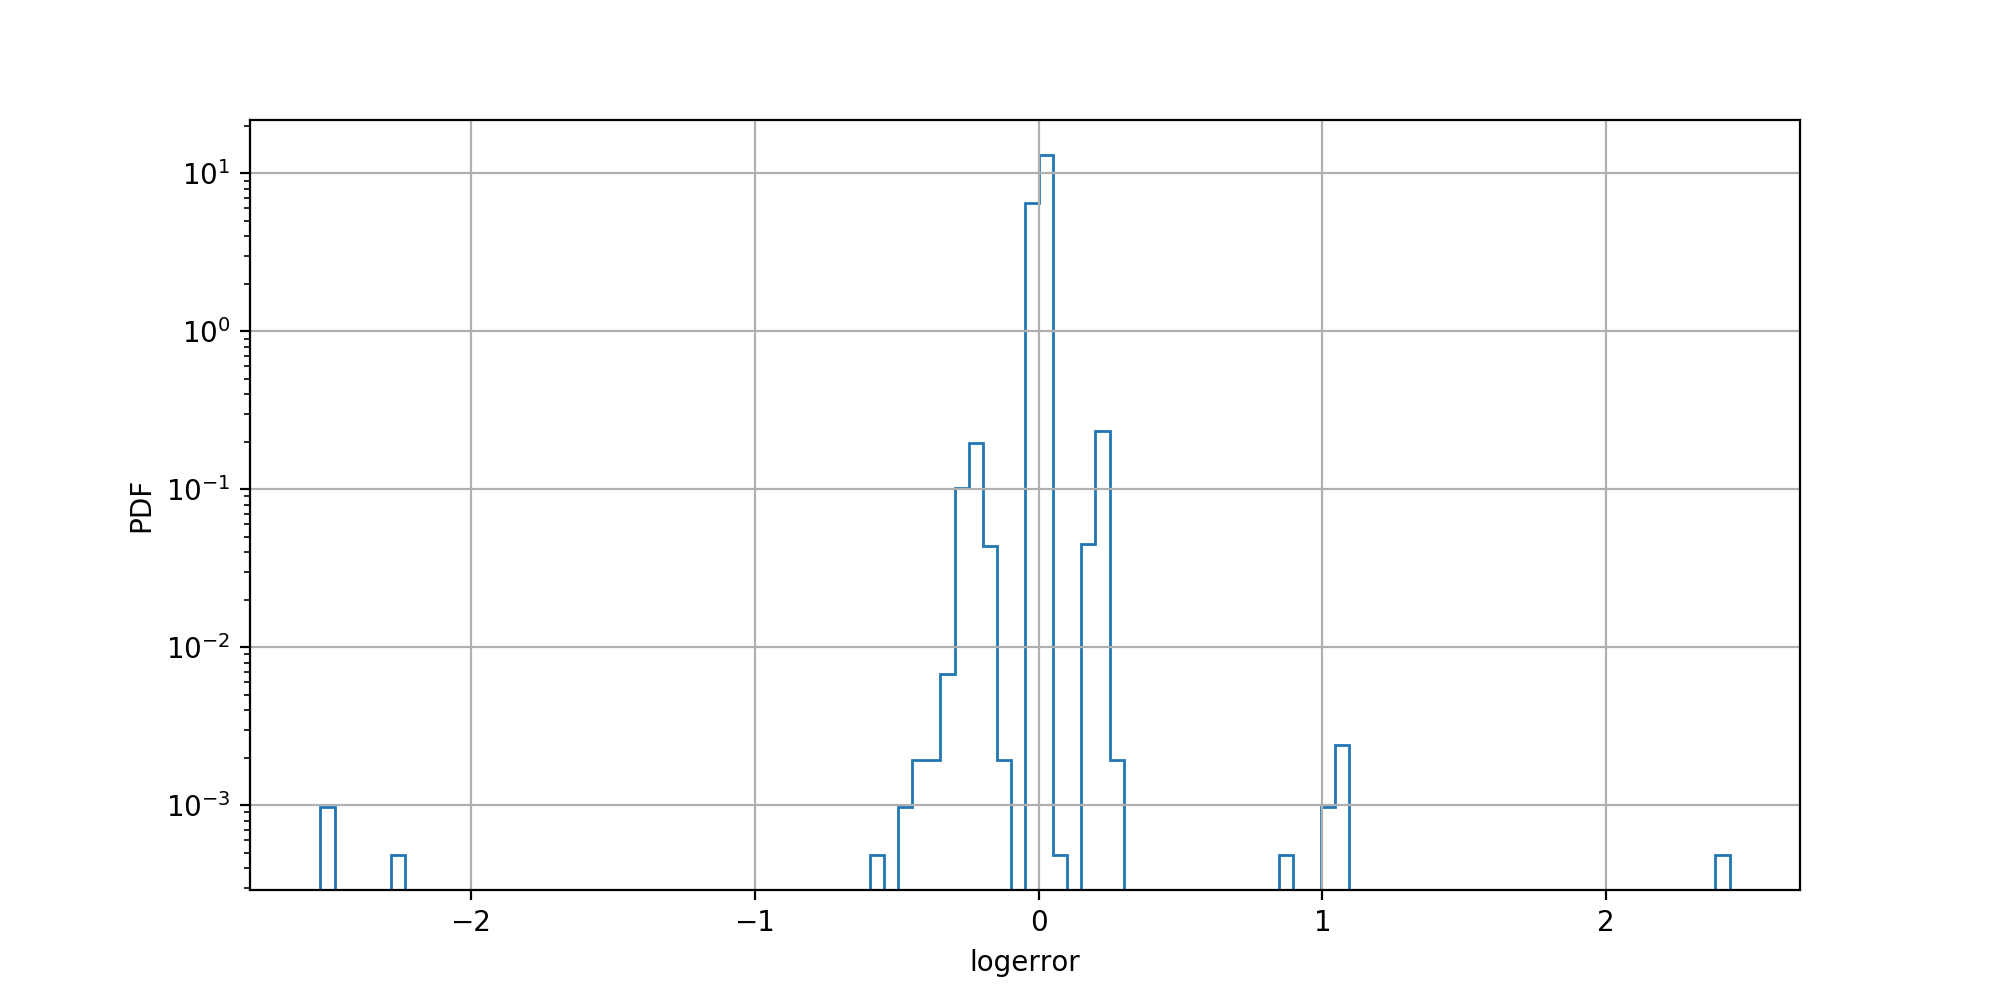

In [114]:
#x=[-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5]

plt.figure(figsize = (10,5))
plt.hist(Results['predicted'], bins=100, density=True, histtype='step')
#plt.hist(Results['real'], bins=100, density=True, histtype='step')
plt.yscale('log')
plt.xlabel('logerror')
#plt.xticks(x)
#plt.xlim([-6,6])
plt.ylabel('PDF')
plt.grid(True)